# Feature Selection for D-Features

## import libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

## load data

In [0]:
dataframe = pd.read_csv('data/all_D_features.csv')
dataframe.head()

,Unnamed: 0,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,isFraud
0,0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,0
1,1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0
2,2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,0
3,3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,0
4,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## get some basic info about the data

In [0]:
dataframe.describe()

,Unnamed: 0,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,isFraud
count,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,590540.000000
mean,295269.500000,94.347568,169.563231,28.343348,140.002441,42.335965,69.805717,41.638950,146.058108,0.561057,123.982137,146.621465,54.037533,17.901295,57.724444,163.744579,0.034990
std,170474.358321,157.660387,177.315865,62.384721,191.096774,89.000144,143.669253,99.743264,231.663840,0.316880,182.615225,186.042622,124.274558,67.614425,136.312450,202.726660,0.183755
min,0.000000,0.000000,0.000000,0.000000,-122.000000,0.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,-83.000000,0.000000,-193.000000,-83.000000,0.000000
25%,147634.750000,0.000000,26.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.958333,0.208333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,295269.500000,3.000000,97.000000,8.000000,26.000000,10.000000,0.000000,0.000000,37.875000,0.666666,15.000000,43.000000,0.000000,0.000000,0.000000,52.000000,0.000000
75%,442904.250000,122.000000,276.000000,27.000000,253.000000,32.000000,40.000000,17.000000,187.958328,0.833333,197.000000,274.000000,13.000000,0.000000,2.000000,314.000000,0.000000
max,590539.000000,640.000000,640.000000,819.000000,869.000000,819.000000,873.000000,843.000000,1707.791626,0.958333,876.000000,670.000000,648.000000,847.000000,878.000000,879.000000,1.000000


## remove useless column (row ID?)

In [0]:
dataframe = dataframe.drop('Unnamed: 0', axis=1)
dataframe.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,isFraud
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## define utility function to reduce memory usage

In [0]:
def reduce_mem_usage(df, verbose=True):
    """
    Reduce dataframe size

    params:
    - df: dataframe to reduce the size of

    return:
    - dataframe of reduced size
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'float128']
    start_mem = df.memory_usage().sum() / 1024**2    

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float64).min and c_max < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
                elif c_min > np.finfo(np.float128).min and c_max < np.finfo(np.float128).max:
                    df[col] = df[col].astype(np.float128)
                    
    end_mem = df.memory_usage().sum() / 1024**2

    if verbose: 
        print(
            'Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
            end_mem, 100 * (start_mem - end_mem) / start_mem
        ))

    return df

## reduce dataframe size to reduce memory usage

In [0]:
dataframe = reduce_mem_usage(dataframe)

Mem. usage decreased to 17.46 Mb (75.8% reduction)


## check percentage NaNs in each column

In [0]:
for column in dataframe.columns:
    num_nans = dataframe[column].isna().sum()
    print('percentage of NaNs for {}: {:.3f}'.format(
        column, 
        num_nans / len(dataframe) * 100
    ))

percentage of NaNs for D1: 0.215
percentage of NaNs for D2: 47.549
percentage of NaNs for D3: 44.515
percentage of NaNs for D4: 28.605
percentage of NaNs for D5: 52.467
percentage of NaNs for D6: 87.607
percentage of NaNs for D7: 93.410
percentage of NaNs for D8: 87.312
percentage of NaNs for D9: 87.312
percentage of NaNs for D10: 12.873
percentage of NaNs for D11: 47.293
percentage of NaNs for D12: 89.041
percentage of NaNs for D13: 89.509
percentage of NaNs for D14: 89.469
percentage of NaNs for D15: 15.090
percentage of NaNs for isFraud: 0.000


## remove columns with a lot of NaNs

- if we do imputation when there is a lot of NaNs, the imputed value may not be representative of actual value

In [0]:
# keep columns with less than 60% NaNs
dataframe = dataframe.loc[:, dataframe.isna().mean() < 0.6]
dataframe.head()

,D1,D2,D3,D4,D5,D10,D11,D15,isFraud
0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,0
1,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0
2,0.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,0
3,112.0,112.0,0.0,94.0,0.0,84.0,NaN,111.0,0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## define function for drawing correlation heatmap

In [0]:
def draw_correlation_heatmap(df):
    """
    params:
    - df: dataframe of which correlation heatmap is drawn
    """
    fig, ax = plt.subplots(figsize=(10,10))

    sns.heatmap(
        df.corr(), 
        vmax=1.0, 
        center=0, 
        fmt='.2f',
        square=True, 
        linewidths=0.5, 
        annot=True, 
        cbar_kws={'shrink': .70},
    )

    plt.show()

## draw correlation heatmap to check for correlated features

- correlated features may affect classifier performance

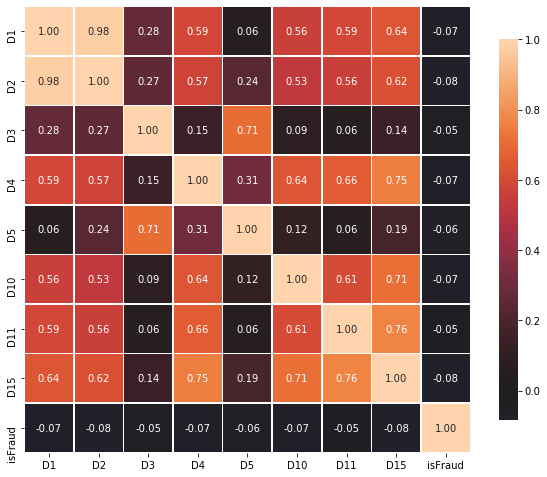

In [0]:
draw_correlation_heatmap(dataframe)

## drop highly-correlated features

In [0]:
dataframe = dataframe.drop(['D2'], axis=1)  # D1 and D2 has correlation coefficient of 0.98
dataframe.head()

,D1,D3,D4,D5,D10,D11,D15,isFraud
0,14.0,13.0,NaN,NaN,13.0,13.0,0.0,0
1,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0
2,0.0,NaN,0.0,NaN,0.0,315.0,315.0,0
3,112.0,0.0,94.0,0.0,84.0,NaN,111.0,0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0


## do imputation to fill in NaNs

In [0]:
# replace NaN with interquartile mean
dataframe = dataframe.fillna(dataframe.quantile().mean())
dataframe.head()

,D1,D3,D4,D5,D10,D11,D15,isFraud
0,14.0,13.000,19.625,19.625,13.000,13.000,0.000,0
1,0.0,19.625,0.000,19.625,0.000,19.625,0.000,0
2,0.0,19.625,0.000,19.625,0.000,315.000,315.000,0
3,112.0,0.000,94.000,0.000,84.000,19.625,111.000,0
4,0.0,19.625,19.625,19.625,19.625,19.625,19.625,0


## separate data into features and target variable

In [0]:
d_features_dataframe = dataframe.drop('isFraud', axis=1)
is_fraud_data = dataframe['isFraud']

## define function for doing RFECV

- Recursive Feature Elimination with Cross Validation

In [0]:
def do_rfecv(features_dataframe, target_variable, classifier, verbose=True):
    """
    Do Recursive Feature Elimination with Cross Validation.
    Scoring method: ROC AUC

    params:
    - features_dataframe: dataframe that contain features only
    - target_variable: series that contain the target variable
    - classifier: classifier for evaluating feature importance
    - verbose (bool): if True, prints info

    return:
    - rfecv
    """
    rfecv = RFECV(classifier, scoring='roc_auc', n_jobs=2)
    rfecv = rfecv.fit(features_dataframe, target_variable)

    if verbose:
        print(f'Optimal number of features: {rfecv.n_features_}')
        print(f'ROC AUC: {rfecv.grid_scores_[rfecv.n_features_ - 1]}')

    return rfecv

## do Recursive Feature Elimination with Cross Validation (RFECV)

- to select most important features
- use random forest for evaluation

In [0]:
%%time

rf_classifier = RandomForestClassifier(n_jobs=2)
rfecv = do_rfecv(d_features_dataframe, is_fraud_data, rf_classifier)

Optimal number of features: 7
ROC AUC: 0.7106897506899459
CPU times: user 2min 14s, sys: 219 ms, total: 2min 14s
Wall time: 9min 58s


## define function to plot accuracy vs number of features

In [0]:
def plot_acc_vs_num_features(grid_scores, method_used):
    plt.figure(figsize=(16, 9))
    plt.title(method_used, fontsize=18, fontweight='bold', pad=20)

    plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
    plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)

    plt.plot(
        range(1, len(grid_scores) + 1), 
        grid_scores, 
        color='#303F9F', 
        linewidth=3,
    )

    plt.show()

## plot line chart of accuracy vs number of features

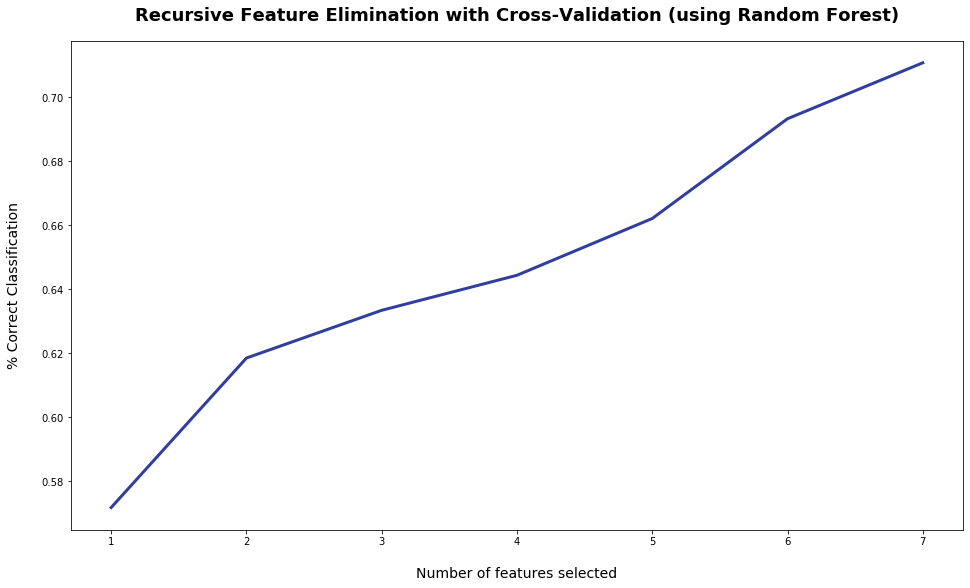

In [0]:
plot_acc_vs_num_features(
    rfecv.grid_scores_, 
    'Recursive Feature Elimination with Cross-Validation (using Random Forest)', 
)

## show feature ranking

In [0]:
for column, rank in zip(d_features_dataframe.columns, rfecv.ranking_):
    print(f'feature: {column} rank: {rank}')

feature: D1 rank: 1
feature: D3 rank: 1
feature: D4 rank: 1
feature: D5 rank: 1
feature: D10 rank: 1
feature: D11 rank: 1
feature: D15 rank: 1


## define function to get only the most important features

In [0]:
def get_important_features(features_dataframe, rfecv, verbose=True):
    least_important_features = np.where(rfecv.support_ == False)[0]

    if verbose:
        print('not-important features:', list(features_dataframe.columns[least_important_features]))

    important_features_dataframe = features_dataframe.drop(
        features_dataframe.columns[least_important_features], 
        axis=1
    )

    if verbose:
        print('important features:', list(important_features_dataframe.columns))

    return important_features_dataframe

## keep only the most important features

In [0]:
most_important_features = get_important_features(d_features_dataframe, rfecv)

not-important features: []
important features: ['D1', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15']


## define function to plot feature importance bar chart

In [0]:
def plot_feature_importance_chart(important_features_dataframe, rfecv):
    plot_dataframe = pd.DataFrame()

    plot_dataframe['attr'] = important_features_dataframe.columns
    plot_dataframe['importance'] = rfecv.estimator_.feature_importances_

    plot_dataframe = plot_dataframe.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(16, 14))
    plt.barh(
        y=plot_dataframe['attr'], 
        width=plot_dataframe['importance'], 
        color='#1976D2',
    )

    plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('Importance', fontsize=14, labelpad=20)

    plt.show()

## plot bar chart for feature importance

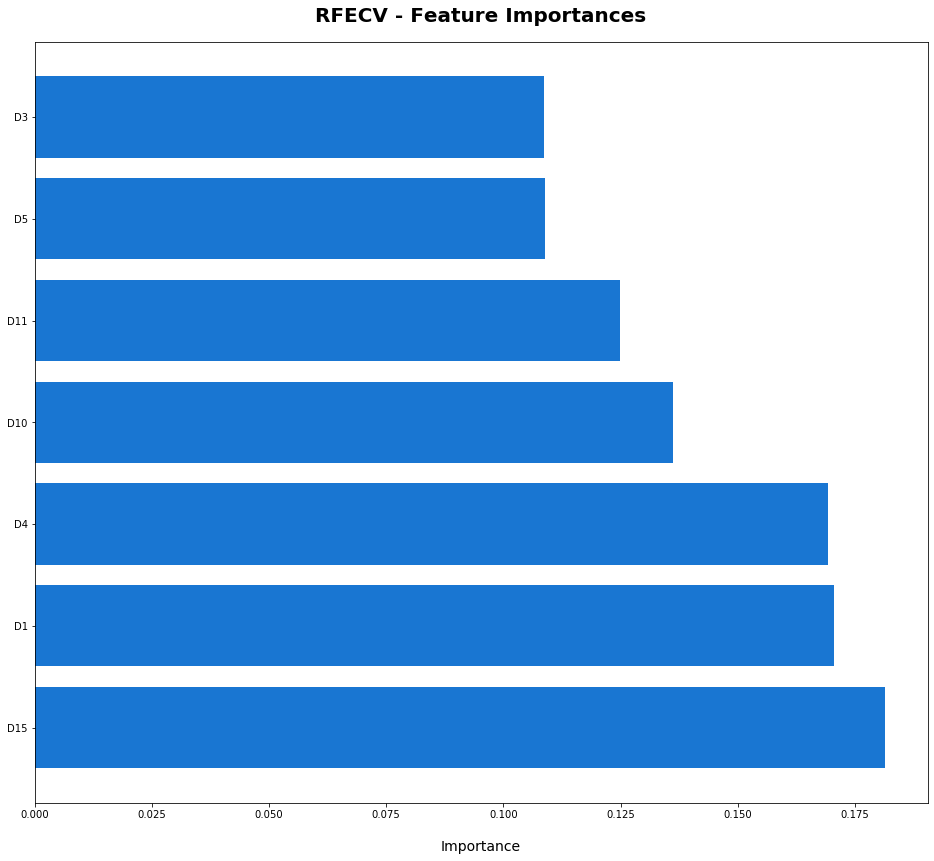

In [0]:
plot_feature_importance_chart(most_important_features, rfecv)

## do RFECV again

- to select most important features
- use light gradient boosting machine for evaluation

In [0]:
%%time

lgbm_classifier = LGBMClassifier()
rfecv = do_rfecv(d_features_dataframe, is_fraud_data, lgbm_classifier)

Optimal number of features: 7
ROC AUC: 0.7679062923604875
CPU times: user 38.4 s, sys: 480 ms, total: 38.9 s
Wall time: 41.6 s


## plot line chart of accuracy vs number of features

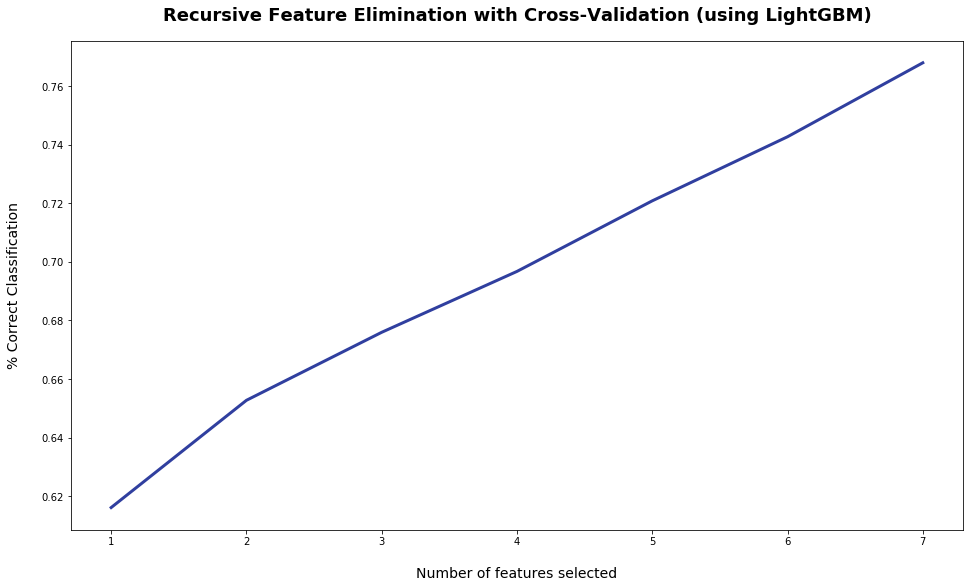

In [0]:
plot_acc_vs_num_features(
    rfecv.grid_scores_, 
    'Recursive Feature Elimination with Cross-Validation (using LightGBM)', 
)

## show feature ranking

In [0]:
for column, rank in zip(d_features_dataframe.columns, rfecv.ranking_):
    print(f'feature: {column} rank: {rank}')

feature: D1 rank: 1
feature: D3 rank: 1
feature: D4 rank: 1
feature: D5 rank: 1
feature: D10 rank: 1
feature: D11 rank: 1
feature: D15 rank: 1


## keep only the most important features

In [0]:
most_important_features = get_important_features(d_features_dataframe, rfecv)

not-important features: []
important features: ['D1', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15']


## plot bar chart for feature importance

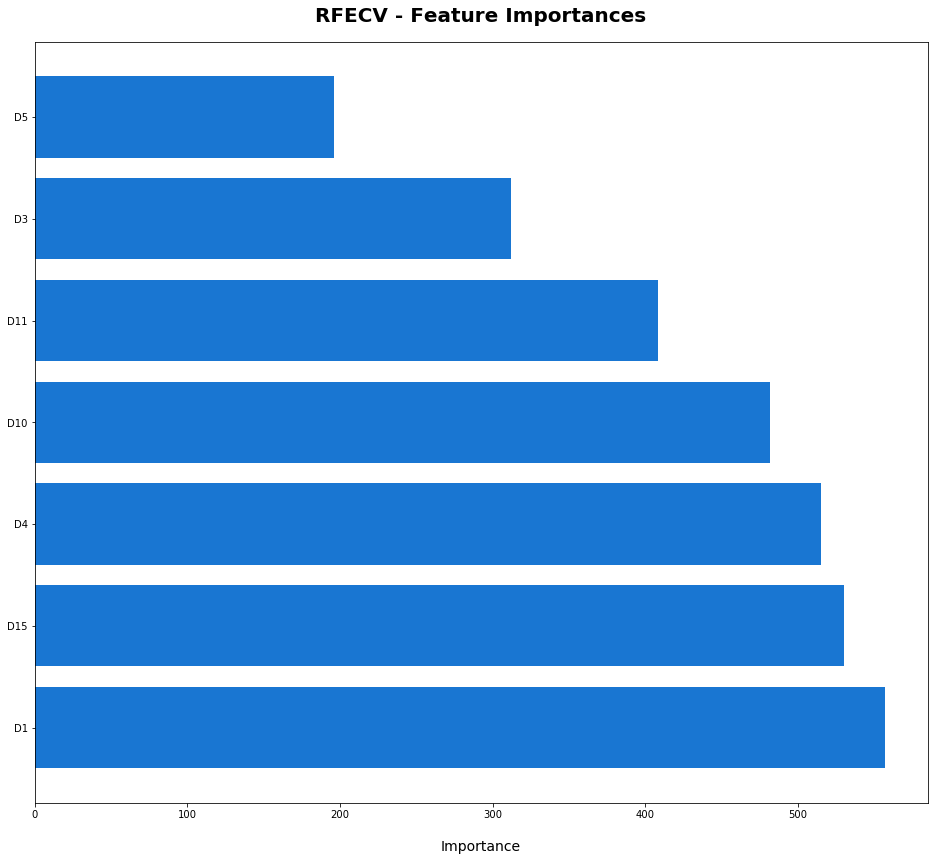

In [0]:
plot_feature_importance_chart(most_important_features, rfecv)

## apparently, [decision trees can deal with multicollinearity](https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4)

- check if using D2 would increase ROC AUC

In [0]:
# not dropping D2 this time
dataframe = pd.read_csv('data/all_D_features.csv')
dataframe = dataframe.drop('Unnamed: 0', axis=1)
dataframe = reduce_mem_usage(dataframe)
dataframe = dataframe.loc[:, dataframe.isna().mean() < 0.6]
dataframe = dataframe.fillna(dataframe.quantile().mean())

Mem. usage decreased to 17.46 Mb (75.8% reduction)


## separate data into features and target variable

In [0]:
d_features_dataframe = dataframe.drop('isFraud', axis=1)
is_fraud_data = dataframe['isFraud']

## do RFECV

- to select most important features
- use random forest for evaluation

In [0]:
%%time

rf_classifier = RandomForestClassifier(n_jobs=2)
rfecv = do_rfecv(d_features_dataframe, is_fraud_data, rf_classifier)

Optimal number of features: 8
ROC AUC: 0.7197007048704398
CPU times: user 2min 21s, sys: 216 ms, total: 2min 21s
Wall time: 11min 33s


## plot line chart of accuracy vs number of features

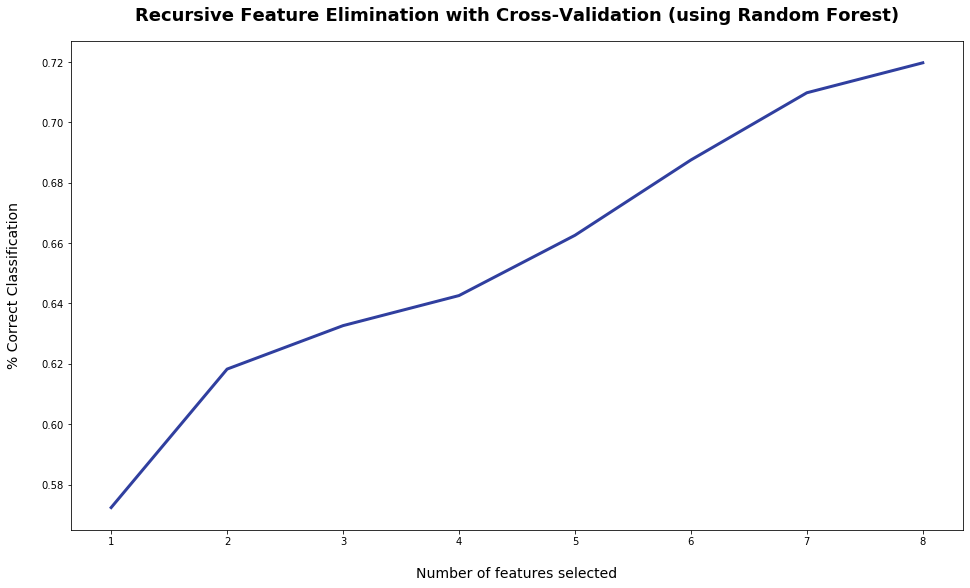

In [0]:
plot_acc_vs_num_features(
    rfecv.grid_scores_, 
    'Recursive Feature Elimination with Cross-Validation (using Random Forest)', 
)

## show feature ranking

In [0]:
for column, rank in zip(d_features_dataframe.columns, rfecv.ranking_):
    print(f'feature: {column} rank: {rank}')

feature: D1 rank: 1
feature: D2 rank: 1
feature: D3 rank: 1
feature: D4 rank: 1
feature: D5 rank: 1
feature: D10 rank: 1
feature: D11 rank: 1
feature: D15 rank: 1


## keep only the most important features

In [0]:
most_important_features = get_important_features(d_features_dataframe, rfecv)

not-important features: []
important features: ['D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15']


## plot bar chart for feature importance

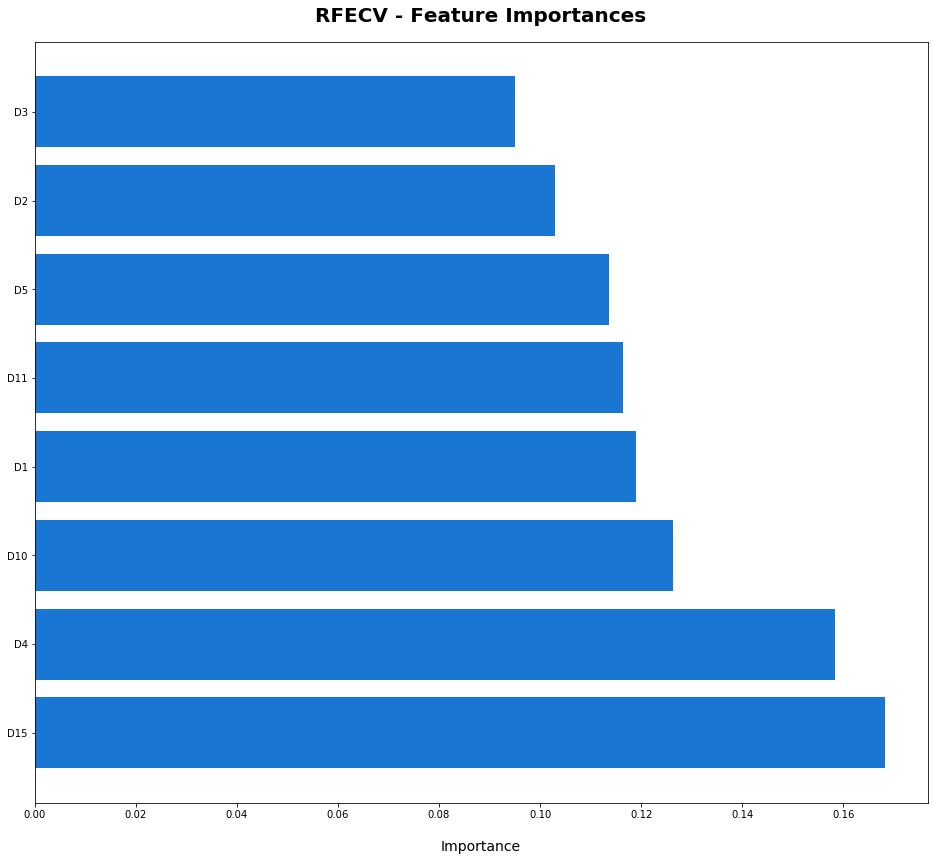

In [0]:
plot_feature_importance_chart(most_important_features, rfecv)

## do RFECV again

- to select most important features
- use light gradient boosting machine for evaluation

In [0]:
%%time

lgbm_classifier = LGBMClassifier()
rfecv = do_rfecv(d_features_dataframe, is_fraud_data, lgbm_classifier)

Optimal number of features: 8
ROC AUC: 0.77288522852928
CPU times: user 39.7 s, sys: 392 ms, total: 40.1 s
Wall time: 47.2 s


## plot line chart of accuracy vs number of features

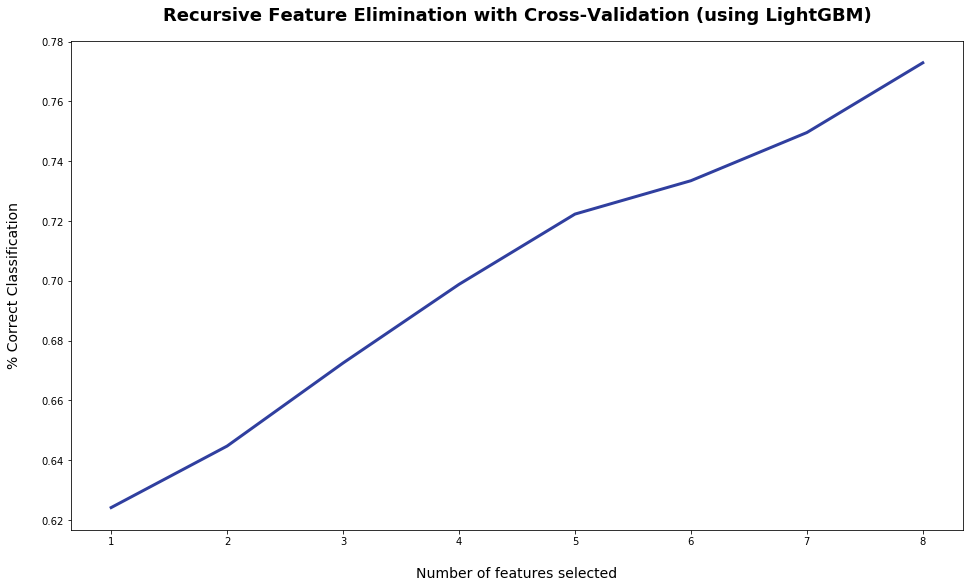

In [0]:
plot_acc_vs_num_features(
    rfecv.grid_scores_, 
    'Recursive Feature Elimination with Cross-Validation (using LightGBM)', 
)

## show feature ranking

In [0]:
for column, rank in zip(d_features_dataframe.columns, rfecv.ranking_):
    print(f'feature: {column} rank: {rank}')

feature: D1 rank: 1
feature: D2 rank: 1
feature: D3 rank: 1
feature: D4 rank: 1
feature: D5 rank: 1
feature: D10 rank: 1
feature: D11 rank: 1
feature: D15 rank: 1


## keep only the most important features

In [0]:
most_important_features = get_important_features(d_features_dataframe, rfecv)

not-important features: []
important features: ['D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15']


## plot bar chart for feature importance

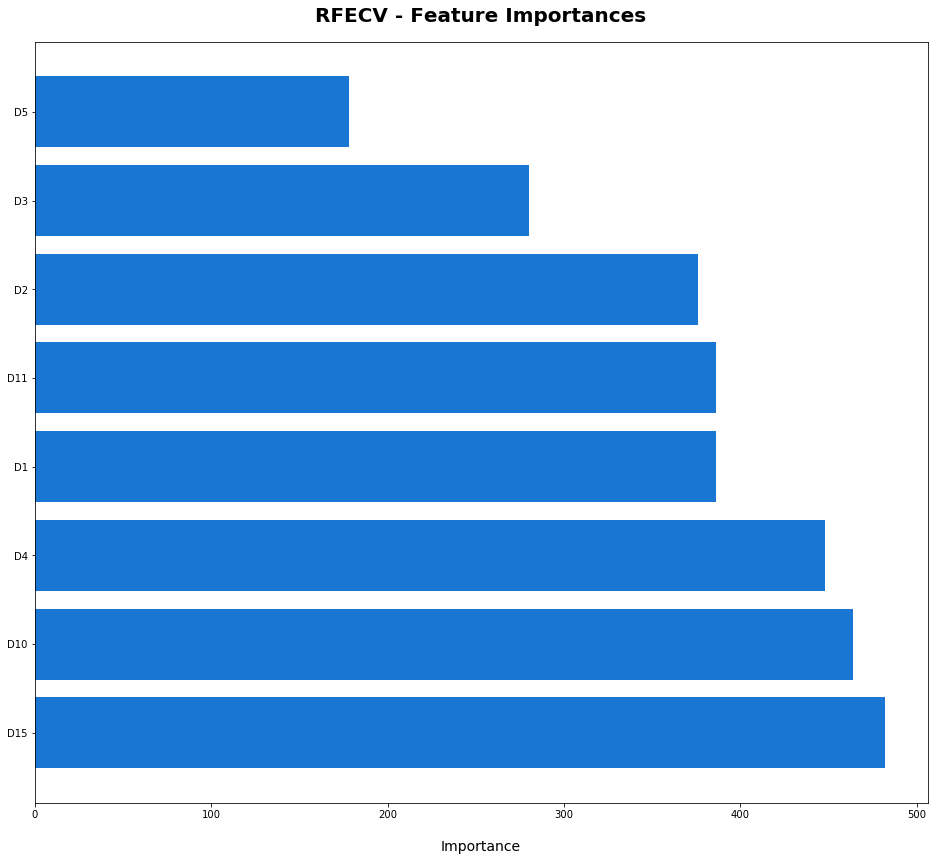

In [0]:
plot_feature_importance_chart(most_important_features, rfecv)

## Result

### without D2

using Random Forest

- Optimal number of features: 7
- ROC AUC: 0.7106897506899459
- not-important features: None
- important features: 'D1', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15'

using LightGBM

- Optimal number of features: 7
- ROC AUC: 0.7679062923604875
- not-important features: None
- important features: 'D1', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15'

### with D2

using Random Forest

- Optimal number of features: 8
- ROC AUC: 0.7197007048704398
- not-important features: None
- important features: 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15'

using LightGBM

- Optimal number of features: 8
- ROC AUC: 0.77288522852928
- not-important features: None
- important features: 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15'